In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from string import punctuation
print(punctuation)
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


clean the original data

In [14]:
df = pd.read_csv("SET_processed_latest_version.csv")
for i in range(df.shape[1]):
    df.iloc[:,i]= df.iloc[:,i].replace([555, 777,888,999,'555','777','888','999' ], np.nan)
text=df.loc[:,['GRYD_ETO_ID','S6b_Other_Activities','S11a_Comments','A1_Description','A2_Description','A3_Description','O1_other_group_name','Group_name_part1','PUSH_1','PULL_1']]
text["text_all"] = text.apply(lambda x: ','.join(x.dropna()), axis=1)

In [20]:
df= pd.read_csv('text_emotion.csv')

In [21]:
df=df.loc[:,['sentiment','content']]

In [22]:
df.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

normalize function

In [16]:
import re, string

def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [17]:
from nltk.corpus import stopwords
sw = stopwords.words('english')

def  normalize (df):
    contents=df.dropna().values
    

    
    
    for i in range (contents.shape[0]):
        contents[i]=contents[i].replace(",", " ")
        
    all_contents = [''.join([c for c in i if c not in punctuation]) for i in contents]
    all_contents = [i.lower() for i in all_contents]
    all_contents= [i.split() for i in all_contents]
    
    for i in range (len(all_contents)):
        all_contents[i]=remove_noise(all_contents[i],sw)
    
    
    clean_tokens = [[] for _ in range(len(all_contents))]
    other_trash = ['im','a','u','2','wont','thats','dont', 'cant', 'didnt','isnt','ive','doesnt']
    trash_tokens = sw + other_trash
    for i in range(len(all_contents)):
        for token in all_contents[i]:
            if token not in trash_tokens:
                clean_tokens[i].append(token)
       
    

    
    return clean_tokens

In [18]:
original = normalize(text['S11a_Comments'])

combine data + sample data exploration

In [35]:
df1=pd.read_csv('data_train.csv')

In [36]:
df2=pd.read_csv('data_test.csv')

In [25]:
df=df.rename(columns={'content':'selected_text'})

In [38]:
dfnew=pd.concat([df1, df2], ignore_index=True)

In [39]:
dfnew=dfnew.rename(columns={'Emotion':'sentiment','Text':'selected_text'})

In [40]:
df=pd.concat([df, dfnew], ignore_index=True)

In [26]:
df.shape

(40000, 2)

seperate to train_test

In [72]:
df=pd.concat([df.loc[df['sentiment']=='fear'], df.loc[df['sentiment']=='sadness'],df.loc[df['sentiment']=='neutral'],df.loc[df['sentiment']=='worry'],df.loc[df['sentiment']=='boredom'],df.loc[df['sentiment']=='anger']], ignore_index=True)
df=df.sample(frac=1)
train=df.iloc[:25000,]
train.to_csv('emotion_train.csv',index=False)
test=df.iloc[25000:,]
test.to_csv('emotion_test.csv',index=False)

In [7]:
df.to_csv('emotion.csv', index = False)

.....


In [28]:
#fear = normalize(df.loc[df['sentiment']=='fear']['selected_text'])
sadness = normalize(df.loc[df['sentiment']=='sadness']['selected_text'])
neutral = normalize(df.loc[df['sentiment']=='neutral']['selected_text'])
worry = normalize(df.loc[df['sentiment']=='worry']['selected_text'])

boredom = normalize(df.loc[df['sentiment']=='boredom']['selected_text'])
anger = normalize(df.loc[df['sentiment']=='anger']['selected_text'])

most common tokens for sadness categories

In [33]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token
sadness_words = get_all_words(worry)

In [34]:
from nltk import FreqDist

freq_dist_pos = FreqDist(sadness_words)
print(freq_dist_pos.most_common(100))

[('get', 1113), ('go', 997), ('good', 533), ('day', 530), ('work', 503), ('like', 467), ('feel', 445), ('think', 429), ('know', 384), ('miss', 365), ('today', 362), ('want', 334), ('time', 332), ('need', 330), ('make', 323), ('one', 311), ('really', 310), ('sorry', 309), ('back', 306), ('bad', 303), ('see', 281), ('still', 278), ('hope', 260), ('oh', 250), ('well', 249), ('sad', 243), ('look', 243), ('home', 242), ('night', 232), ('lol', 232), ('much', 227), ('come', 220), ('try', 215), ('wish', 212), ('take', 211), ('last', 208), ('sleep', 200), ('find', 197), ('amp', 194), ('thing', 189), ('ill', 183), ('say', 177), ('tomorrow', 174), ('sick', 173), ('love', 172), ('would', 169), ('new', 166), ('hurt', 161), ('twitter', 157), ('gonna', 156), ('wait', 152), ('leave', 150), ('though', 149), ('week', 147), ('tonight', 144), ('right', 142), ('hour', 135), ('watch', 135), ('please', 134), ('could', 133), ('way', 132), ('morning', 126), ('start', 125), ('happy', 124), ('next', 124), ('soon

change the data type to fit the naive bayes model

In [35]:
def get_tweets_for_model(cleaned_tokens_list):
    
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)



In [36]:
#fear_new = get_tweets_for_model(fear)
sadness_new = get_tweets_for_model(sadness)
neutral_new = get_tweets_for_model(neutral)
worry_new = get_tweets_for_model(worry)

boredom_new = get_tweets_for_model(boredom)
anger_new = get_tweets_for_model(anger)

In [38]:
import random
#fear_data = [(i, "fear")for i in fear_new]
sadness_data = [(i, "sadness")for i in sadness_new]
neutral_data = [(i, "neutral")for i in neutral_new]
worry_data = [(i, "worry")for i in worry_new]

boredom_data = [(i, "boredom")for i in boredom_new]
anger_data = [(i, "anger")for i in anger_new]

In [39]:
anger_data[0]

({'fuckinm': True, 'transtelecom': True}, 'anger')

train test split, fit naive bayes model

In [40]:
dataset =  sadness_data +neutral_data+worry_data+boredom_data+anger_data

len(dataset)


22551

In [41]:
random.shuffle(dataset)

train_data = dataset[:19000]
test_data = dataset[19000:]

In [42]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.2219093213179386
Most Informative Features
              accomplish = True            anger : worry  =    122.5 : 1.0
           taylorswift13 = True            anger : worry  =    122.5 : 1.0
                 fifteen = True           boredo : neutra =     80.1 : 1.0
                     110 = True            anger : neutra =     74.8 : 1.0
              allnighter = True            anger : neutra =     74.8 : 1.0
                    bein = True            anger : neutra =     74.8 : 1.0
                   blond = True            anger : neutra =     74.8 : 1.0
                   brown = True            anger : neutra =     74.8 : 1.0
                bullshit = True            anger : neutra =     74.8 : 1.0
                   chest = True            anger : neutra =     74.8 : 1.0
None


In [43]:
print(classifier.classify(dict([token, True] for token in original[10])))

worry


add sentiment column to original text df

In [44]:
sentiment=list()
for i in range (len(original)):
    sentiment.append(classifier.classify(dict([token, True] for token in original[i])))

In [45]:
text['sentiment']=np.nan
text.head()

,GRYD_ETO_ID,S6b_Other_Activities,S11a_Comments,A1_Description,A2_Description,A3_Description,O1_other_group_name,Group_name_part1,PUSH_1,PULL_1,text_all,sentiment
0,BVCB-0-144-1,"Working out, CBT, boxing","School. Poor grades, car accident, not enough ...",School,NaN,School,Other group,Group,Somebody got out of jail that brought a lot of...,School. work. moving,"BVCB-0-144-1,Working out, CBT, boxing,School. ...",NaN
1,BVCB-0-174-1,Basketball,Mother died,Basketball,NaN,NaN,No name,Money Gang,NaN,NaN,"BVCB-0-174-1,Basketball,Mother died,Basketball...",NaN
2,Southeast 3-10-24-1,Extra activities with children,Favor cousin was murder and never found his ki...,"Church, job and school",Church choir and praise team,NaN,Church group,No group,NaN,NaN,"Southeast 3-10-24-1,Extra activities with chil...",NaN
3,Southeast 3-10-18-1,Actor/dance,Best friend brother was murder [sic] by 16 and...,"Church, school and job",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Southeast 3-10-18-1,Actor/dance,Best friend br...",NaN
4,Southeast 3-10-17-1,Singing,Best fried brother was murder [sic] by 18yr boy,"Church, job, and school",Church choir and praise team,NaN,No name,No name,NaN,NaN,"Southeast 3-10-17-1,Singing,Best fried brother...",NaN


In [46]:
temp=0
for i in range (text.shape[0]):
    if (type(text.loc[i,'S11a_Comments'])==str):
        text.loc[i,'sentiment']=sentiment[temp]
        temp=temp+1


In [47]:
text.loc[:,['S11a_Comments','sentiment']].head(10)

,S11a_Comments,sentiment
0,"School. Poor grades, car accident, not enough ...",worry
1,Mother died,worry
2,Favor cousin was murder and never found his ki...,anger
3,Best friend brother was murder [sic] by 16 and...,anger
4,Best fried brother was murder [sic] by 18yr boy,boredom
5,Best friend brother was murder [sic] by 22yr m...,boredom
6,NaN,NaN
7,NaN,NaN
8,My mom going to jail,worry
9,Broke up with my long time boyfriend.,worry


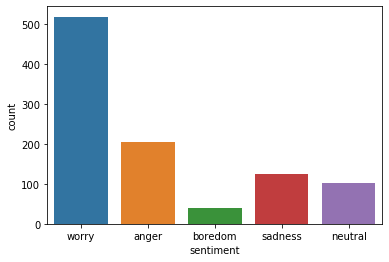

In [48]:
sns.countplot(text['sentiment'])

## correlation finding

inner join two dataframe with key = id, value = sentiment and risk-score

In [34]:
text.shape

(2765, 12)

In [35]:
df=pd.read_csv('zscore_with_id.csv')

In [36]:
df.shape

(1319, 7)

In [63]:
risk=df.loc[:,['gangid','sum']]
risk.head()

,gangid,sum
0,BVCB-0-144-1,-7.812063
1,BVCB-0-174-1,2.120676
2,BVCB-0-174-1,2.965543
5,Southeast 3-10-18-1,-8.555216
6,Southeast 3-10-17-1,-8.555216


In [38]:

emotion=text.loc[:,['GRYD_ETO_ID','sentiment']]

In [39]:
emotion=emotion.rename(columns={'GRYD_ETO_ID':'gangid'})
emotion.shape

(2765, 2)

In [40]:
merged_inner = pd.merge(left=emotion, right=risk, left_on='gangid', right_on='gangid')

In [41]:
merged_inner.shape

(2021, 3)

In [42]:
df=merged_inner.dropna()

In [43]:
df.shape

(719, 3)

In [44]:
df.head()
#df is the final one

,gangid,sentiment,sum
0,BVCB-0-144-1,fear,-7.812063
1,BVCB-0-174-1,sadness,2.120676
2,BVCB-0-174-1,sadness,2.965543
5,Southeast 3-10-18-1,boredom,-8.555216
6,Southeast 3-10-17-1,boredom,-8.555216


Text(0, 0.5, 'z_score')

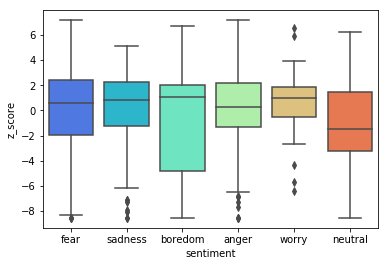

In [45]:
sns.boxplot(x='sentiment',y='sum',data=df,palette='rainbow')
plt.ylabel('z_score')

Text(0, 0.5, 'z_score')

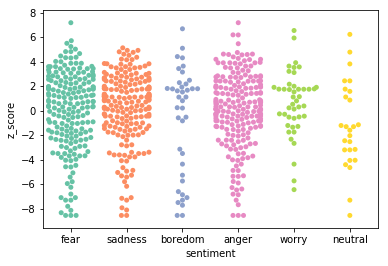

In [46]:
sns.swarmplot(x='sentiment',y='sum',data=df,palette='Set2')
plt.ylabel('z_score')

do the same with activity and risk-score

In [67]:
activity=pd.read_csv('SET_S6b_Activities_Categorized.csv')

In [68]:
activity=activity.drop(columns = "Unnamed: 0")

In [83]:
activity=activity.rename(columns={'GRYD_ETO_ID':'gangid'})
activity=activity.dropna()

In [94]:
activity_new = pd.DataFrame(activity.Categorized_Activities.str.split(', ').tolist(), index=activity.gangid).stack()
activity_new = activity_new.reset_index([0, 'gangid'])
activity_new.columns = ['gangid', 'categorized_activity']
activity_new.head()

,gangid,categorized_activity
0,BVCB-0-144-1,sports
1,BVCB-0-174-1,sports
2,Southeast 3-10-24-1,volunteer
3,Southeast 3-10-18-1,art
4,Southeast 3-10-17-1,art


In [95]:
merged_new = pd.merge(left=activity_new, right=risk, left_on='gangid', right_on='gangid')

Text(0, 0.5, 'z_score')

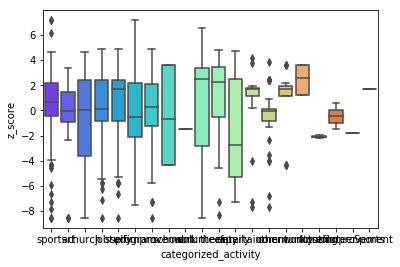

In [96]:
sns.boxplot(x='categorized_activity',y='sum',data=merged_new,palette='rainbow')
plt.ylabel('z_score')

!!!!!!!!!!!!!!! too many actvities, re-grouping

In [182]:
contents=merged_new['categorized_activity'].dropna().values
freq = nltk.FreqDist(contents)
freq

FreqDist({'job': 183, 'sports': 164, 'study': 128, 'selfimprovement': 105, 'program': 84, 'volunteer': 67, 'other': 45, 'church': 42, 'art': 40, 'therapy': 39, ...})

In [183]:
from collections import Counter
plot_dict = dict(Counter(freq).most_common(50))
plot_dict

{'job': 183,
 'sports': 164,
 'study': 128,
 'selfimprovement': 105,
 'program': 84,
 'volunteer': 67,
 'other': 45,
 'church': 42,
 'art': 40,
 'therapy': 39,
 'entertainment': 20,
 'family': 10}

In [184]:
merged_new.loc[merged_new['categorized_activity'] == 'work', 'categorized_activity'] = 'job'
merged_new.loc[merged_new['categorized_activity'] == 'Sports', 'categorized_activity'] = 'sports'
merged_new.loc[merged_new['categorized_activity'] == 'school', 'categorized_activity'] = 'study'
merged_new.loc[merged_new['categorized_activity'] == 'voluteer', 'categorized_activity'] = 'volunteer'
merged_new.loc[merged_new['categorized_activity'] == 'workout', 'categorized_activity'] = 'sports'
merged_new.loc[merged_new['categorized_activity'] == 'tutoring', 'categorized_activity'] = 'other'
merged_new.loc[merged_new['categorized_activity'] == 'community', 'categorized_activity'] = 'volunteer'
merged_new.loc[merged_new['categorized_activity'] == 'sefimprovement', 'categorized_activity'] = 'selfimprovement'
#merged_new is the final one

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

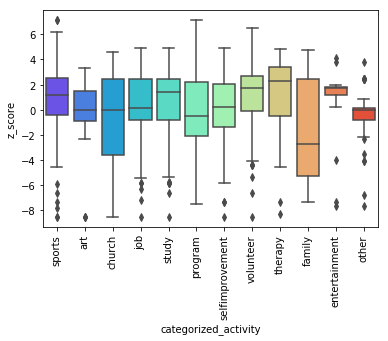

In [185]:
sns.boxplot(x='categorized_activity',y='sum',data=merged_new,palette='rainbow')
plt.ylabel('z_score')
plt.xticks(rotation=90)

In [186]:
contents=merged_new['categorized_activity'].dropna().values
freq = nltk.FreqDist(contents)
from collections import Counter
plot_dict = dict(Counter(freq).most_common(50))
plot_dict

{'job': 183,
 'sports': 164,
 'study': 128,
 'selfimprovement': 105,
 'program': 84,
 'volunteer': 67,
 'other': 45,
 'church': 42,
 'art': 40,
 'therapy': 39,
 'entertainment': 20,
 'family': 10}

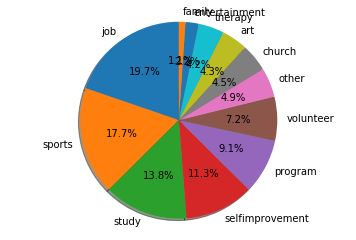

In [187]:
labels = plot_dict.keys()
sizes = plot_dict.values()


fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

do the same with gender and age 

In [188]:
ag=pd.read_csv('SET_processed_latest_version.csv')

In [189]:
ag=ag.loc[:,['GRYD_ETO_ID','AGE_1_FB','SEX_1']]
ag=ag.rename(columns={'GRYD_ETO_ID':'gangid','AGE_1_FB':'age','SEX_1':'sex'})

In [190]:
ag = pd.merge(left=ag, right=risk, left_on='gangid', right_on='gangid')

In [191]:
ag.head()

,gangid,age,sex,sum
0,BVCB-0-144-1,20.0,2,-7.812063
1,BVCB-0-174-1,21.0,1,2.120676
2,BVCB-0-174-1,21.0,1,2.965543
3,BVCB-0-174-1,20.0,1,2.120676
4,BVCB-0-174-1,20.0,1,2.965543


Text(0, 0.5, 'z_score')

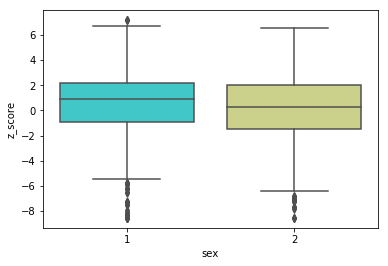

In [192]:
sns.boxplot(x='sex',y='sum',data=ag,palette='rainbow')
plt.ylabel('z_score')

In [193]:
for i in range (13,18):
    ag.loc[ag['age'] == i, 'age'] = '13-17'
    
for i in range (18,25):
    ag.loc[ag['age'] == i, 'age'] = '19-24'
    
for i in range (25,31):
    ag.loc[ag['age'] == i, 'age'] = '25-30'
    
for i in range (31,38):
    ag.loc[ag['age'] == i, 'age'] = '31-37'    

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

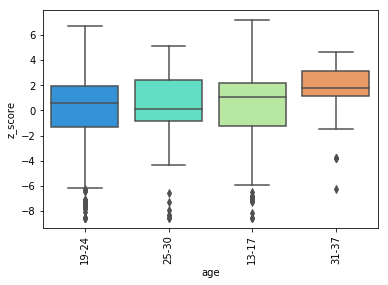

In [194]:
sns.boxplot(x='age',y='sum',data=ag,palette='rainbow')
plt.ylabel('z_score')
plt.xticks(rotation=90)

In [179]:
ag

,gangid,age,sex,sum
0,BVCB-0-144-1,19-25,2,-7.812063
1,BVCB-0-174-1,19-25,1,2.120676
2,BVCB-0-174-1,19-25,1,2.965543
3,BVCB-0-174-1,19-25,1,2.120676
4,BVCB-0-174-1,19-25,1,2.965543
5,Southeast 3-10-18-1,25,1,-8.555216
6,Southeast 3-10-17-1,19-25,2,-8.555216
7,Southeast 3-10-19-1,19-25,2,-8.555216
8,Foothill-14-192-1,19-25,2,1.034107
9,BVCB-0-77-1,19-25,2,-5.318873


In [ ]:
emotion